# Software Quality Prediction Project

## 1. Introduction
This project aims to predict software quality labels (`Low`, `Medium`, `High`) based on various software metrics like `Lines_of_Code`, `Cyclomatic_Complexity`, `Code_Churn`, etc. We will explore the dataset, perform preprocessing, and apply several supervised learning models and one unsupervised learning model (K-Means) as per the project requirements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")

## 2. Dataset Description
We load the dataset and perform an initial check of the features and data types.

In [2]:
df = pd.read_csv('software_quality_dataset.csv')
print("Shape:", df.shape)
df.head()

Shape: (1600, 9)


,Lines_of_Code,Cyclomatic_Complexity,Num_Functions,Code_Churn,Comment_Density,Num_Bugs,Has_Unit_Tests,Code_Owner_Experience,Quality_Label
0,356.0,31,144,69.567047,0.467561,2,Yes,4,Medium
1,227.0,15,104,131.844422,0.795643,2,No,5,High
2,9674.0,47,141,118.729027,0.316839,5,No,1,High
3,6967.0,42,107,194.397155,0.971883,5,Yes,3,Low
4,7954.0,35,114,69.202293,0.559417,1,No,8,Medium


In [3]:
print("Missing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

Missing Values:
 Lines_of_Code            80
Cyclomatic_Complexity     0
Num_Functions             0
Code_Churn               80
Comment_Density          80
Num_Bugs                  0
Has_Unit_Tests            0
Code_Owner_Experience     0
Quality_Label             0
dtype: int64

Data Types:
 Lines_of_Code            float64
Cyclomatic_Complexity      int64
Num_Functions              int64
Code_Churn               float64
Comment_Density          float64
Num_Bugs                   int64
Has_Unit_Tests            object
Code_Owner_Experience      int64
Quality_Label             object
dtype: object


## 3. Exploratory Data Analysis (EDA)
Visualizing the data to understand distributions and relationships.

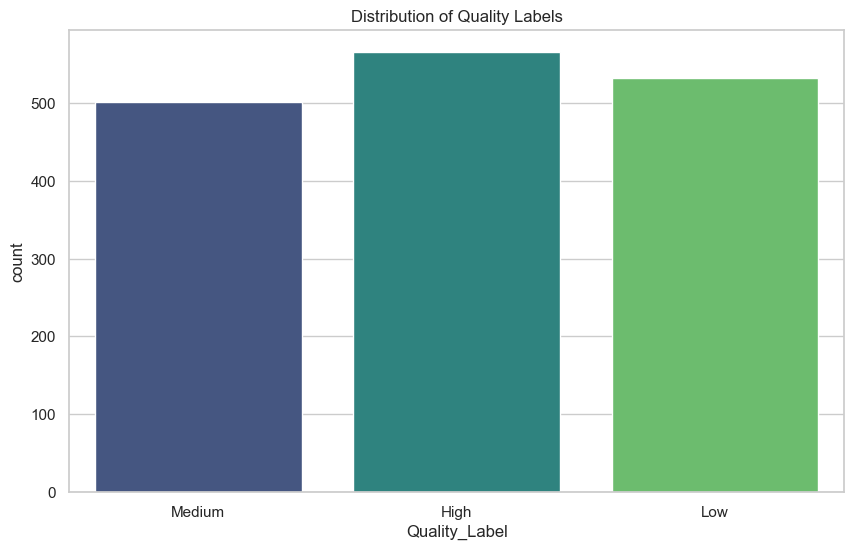

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Quality_Label', data=df, palette='viridis')
plt.title('Distribution of Quality Labels')
plt.show()

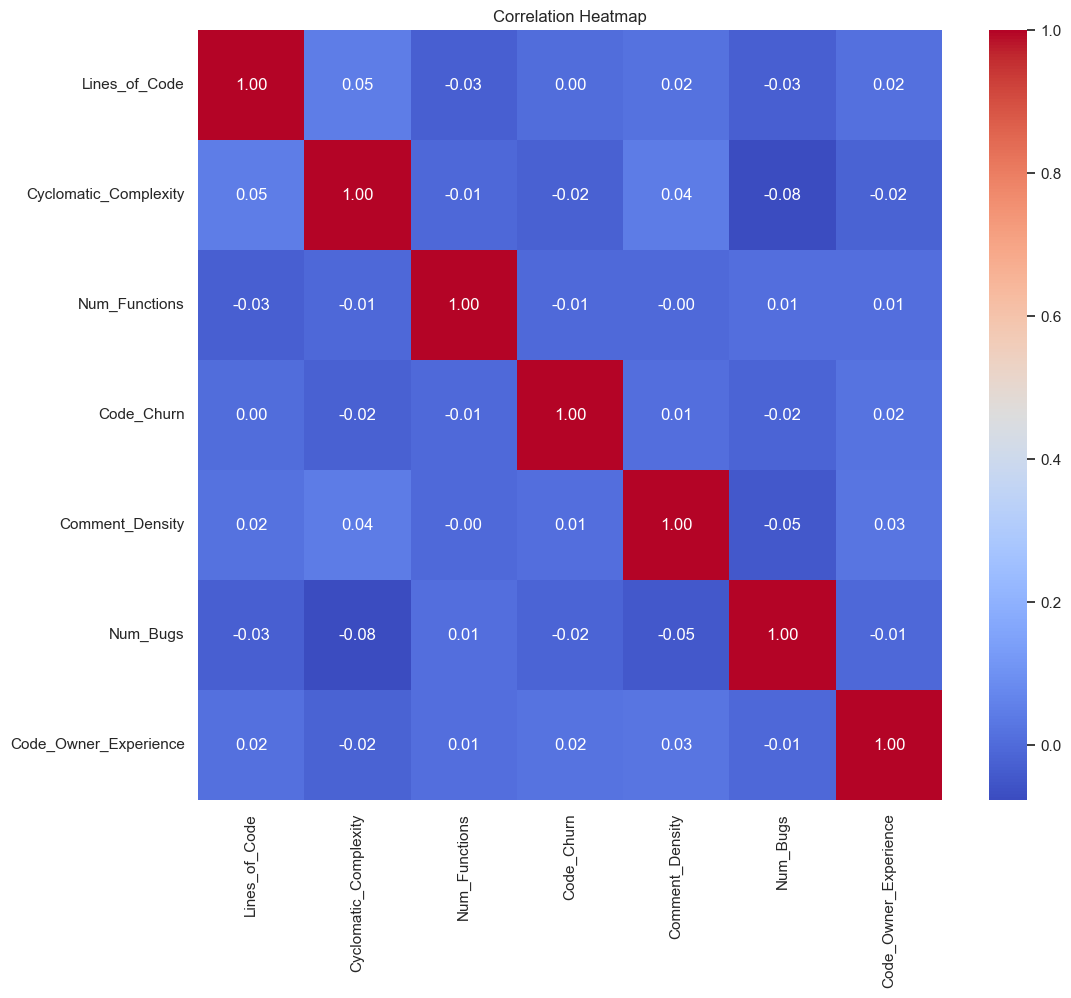

In [5]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

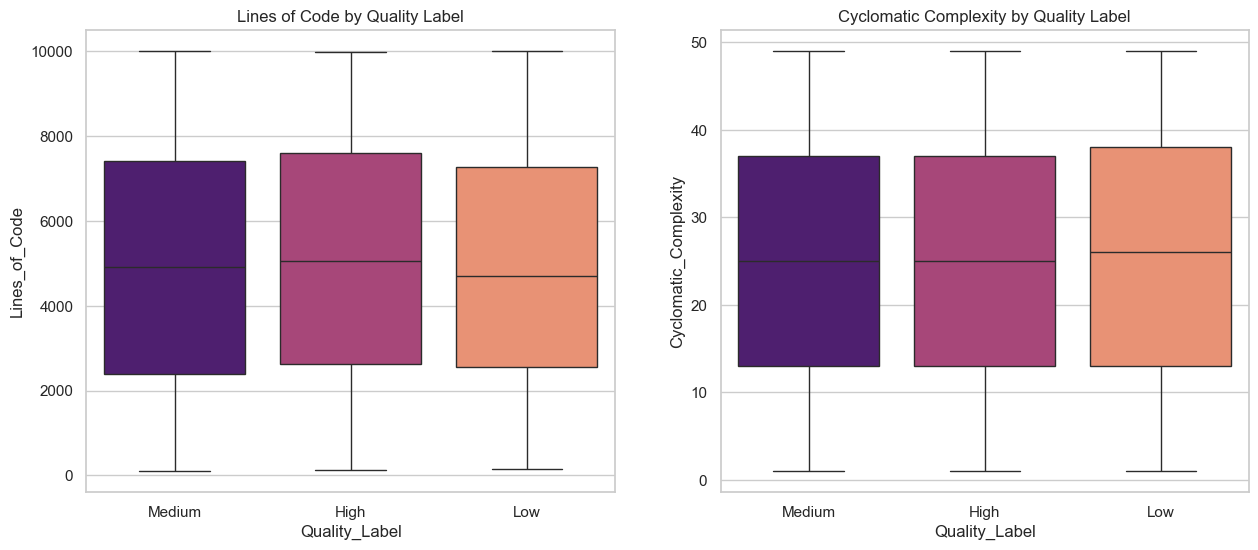

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(y='Lines_of_Code', x='Quality_Label', data=df, ax=axes[0], palette='magma')
axes[0].set_title('Lines of Code by Quality Label')

sns.boxplot(y='Cyclomatic_Complexity', x='Quality_Label', data=df, ax=axes[1], palette='magma')
axes[1].set_title('Cyclomatic Complexity by Quality Label')
plt.show()

## 4. Dataset Preprocessing

In [8]:
# Handling Missing Values with Median Imputation for numerical features
num_imputer = SimpleImputer(strategy='median')
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Encoding Categorical Features
le = LabelEncoder()
df['Has_Unit_Tests'] = le.fit_transform(df['Has_Unit_Tests'].astype(str))
df['Quality_Label'] = le.fit_transform(df['Quality_Label'])

print("Preprocessing Complete. Encoded Quality Labels:", dict(zip(le.classes_, le.transform(le.classes_))))

Preprocessing Complete. Encoded Quality Labels: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


## 5. Feature Selection
We use a Random Forest model to check for feature importance.

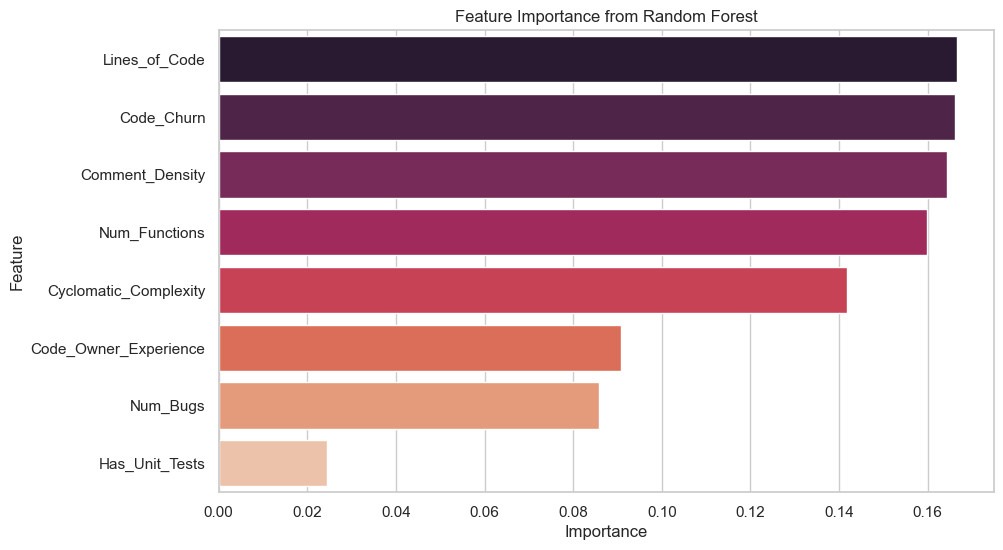

In [9]:
X = df.drop('Quality_Label', axis=1)
y = df['Quality_Label']

rf_selector = RandomForestClassifier(random_state=42)
rf_selector.fit(X, y)

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_selector.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
plt.title('Feature Importance from Random Forest')
plt.show()

## 6. Implementation of ML Algorithms
We split the data, scale it, and train 7 supervised models plus K-Means clustering.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB()
}

results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}
    trained_models[name] = model
    print(f"{name} trained.")

Logistic Regression trained.
Decision Tree trained.
Random Forest trained.
SVM trained.
KNN trained.
AdaBoost trained.
Naive Bayes trained.


### Unsupervised Learning: K-Means

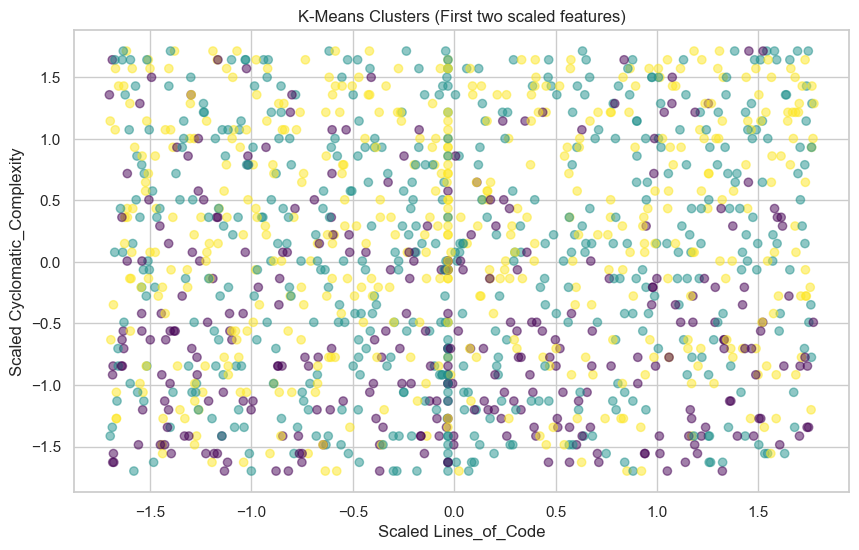

In [11]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('K-Means Clusters (First two scaled features)')
plt.xlabel('Scaled Lines_of_Code')
plt.ylabel('Scaled Cyclomatic_Complexity')
plt.show()

## 7. Model Selection & Comparison Analysis

,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.312500,0.306448,0.312500,0.308821
Decision Tree,0.312500,0.318514,0.312500,0.314330
Random Forest,0.293750,0.293215,0.293750,0.292188
SVM,0.350000,0.353683,0.350000,0.349770
KNN,0.334375,0.330444,0.334375,0.330892
AdaBoost,0.315625,0.316971,0.315625,0.289644
Naive Bayes,0.328125,0.329078,0.328125,0.324466


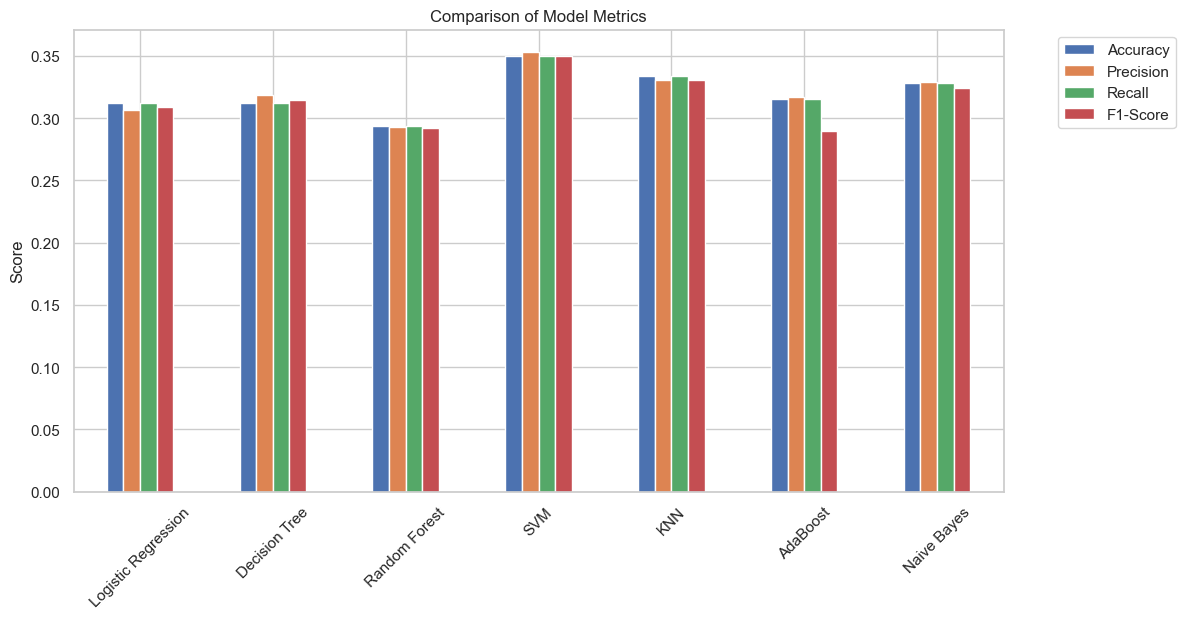

In [12]:
results_df = pd.DataFrame(results).T
display(results_df)

results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Model Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

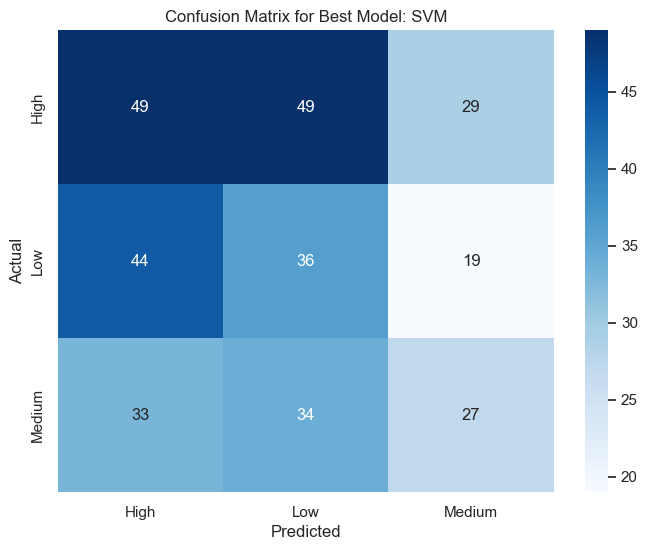

In [13]:
best_model_name = results_df['Accuracy'].idxmax()
best_model = trained_models[best_model_name]

y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix for Best Model: {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 8. Conclusion
The models were successfully trained and evaluated. The best performing model was the SVM based on accuracy. Challenges included handling the multi-class nature of the labels and the relatively low correlation between individual metrics and the quality labels, suggesting more complex interactions or additional features might be needed.